# COMP0173: Coursework 2

The paper HEARTS: A Holistic Framework for Explainable, Sustainable, and Robust Text Stereotype Detection by Theo King, Zekun Wu et al. (2024) presents a comprehensive approach to analysing and detecting stereotypes in text [1]. The authors introduce the HEARTS framework, which integrates model explainability, carbon-efficient training, and accurate evaluation across multiple bias-sensitive datasets. By using transformer-based models such as ALBERT-V2, BERT, and DistilBERT, this research project demonstrates that stereotype detection performance varies significantly across dataset sources, underlining the need for diverse evaluation benchmarks. The paper provides publicly available datasets and code [2], allowing full reproducibility and offering a standardised methodology for future research on bias and stereotype detection in Natural Language Processing (NLP).

# Instructions

All figures produced during this notebook are stored in the project’s `/COMP0173_Figures` directory.
The corresponding LaTeX-formatted performance comparison tables, including ALBERT-V2, BERT, and DistilBERT are stored in `/COMP0173_PDF`, with the compiled document available as `COMP0173-CW2-TABLES.pdf`.

# Technical Implementation (70%)

In [19]:
# %%capture
# pip install -r requirements.txt
# pip install transformers
# pip install --upgrade transformers
# pip install --upgrade tokenizers
# pip install -U sentence-transformers
# pip install natasha
# pip install datasets
# pip install --user -U nltk
# conda install -c anaconda nltk

In [20]:
# pip install -U pip setuptools wheel
# pip install -U spacy
# python -m spacy download en_core_web_trf
# python -m spacy download en_core_web_sm
# python -m spacy download ru_core_news_lg

# # GPU
# pip install -U 'spacy[cuda12x]'
# # GPU - Train Models
# pip install -U 'spacy[cuda12x,transformers,lookups]'

In [21]:
# Import the libraries 
import random, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(color_codes=True)
plt.style.use('seaborn-v0_8')

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')
np.random.seed(23)

warnings.filterwarnings(
    "ignore",
    message="pkg_resources is deprecated as an API"
)

In [22]:
# Import libraries 
import pandas as pd
import os
import sys
import importlib.util, pathlib
from pathlib import Path
import warnings 
from importlib import reload
from importlib.machinery import SourceFileLoader
from IPython.display import display
import pandas as pd
from pathlib import Path
import re
import difflib
import string
from collections import defaultdict
import json

In [23]:
import torch
import transformers
from transformers import AutoModelForMaskedLM, XLMWithLMHeadModel
from transformers import AutoTokenizer, AutoConfig
from transformers import TrainingArguments, Trainer
from sentence_transformers import SentenceTransformer, util
import platform
from datasets import load_dataset
import spacy 

import nltk
from nltk import tokenize
from nltk.tokenize import word_tokenize
nltk.download('punkt')

import natasha
from natasha import (
    Segmenter,
    MorphVocab,

    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,
    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()

segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rinlobachevskii/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:
# # Check the GPU host (UCL access)
# print("CUDA available:", torch.cuda.is_available())
# print("Device:", torch.cuda.get_device_name(0))

# # Path
# import os
# os.chdir("/tmp/HEARTS-Text-Stereotype-Detection")
# os.getcwd()

## Part 2: Identify a contextually relevant challenge in your country or region of your choice that can be addressed using the same AI approach

**Content Warning:**
This notebook contains examples of stereotypes and anti-stereotypes that
may be offensive.

### $\color{pink}{Question\ 1:}$ Problem and SDG alignment

This coursework supports Sustainable Development Goal (SDG) 5: Gender Equality - *Achieve gender equality and empower all women and girls*, SDG 9: Industry, Innovation, and Infrastructure - *Build resilient infrastructure, promote inclusive and sustainable industrialization and foster innovation*, SDG 10: Reduced Inequalities - *Reduce inequality within and among countries*, and SDG 16: Peace, Justice, and Strong Institutions: - *Promote peaceful and inclusive societies for sustainable development, provide access to justice for all and build effective, accountable and inclusive institutions at all levels* [5].

The specific targets covered by this coursework are:

- SDG 5.1: *End all forms of discrimination against all women and girls everywhere*

- SDG 5.b: *Enhance the use of enabling technology, in particular information and communications technology, to promote the empowerment of women*

- SDG 10.2: *By 2030, empower and promote the social, economic and political inclusion of all, irrespective of age, sex, disability, race, ethnicity, origin, religion or economic or other status*

- SDG 10.3: *Ensure equal opportunity and reduce inequalities of outcome, including by eliminating discriminatory laws, policies and practices and promoting appropriate legislation, policies and action in this regard*

- SDG 16.1: *Significantly reduce all forms of violence and related death rates everywhere*

- SDG 16.6: *Develop effective, accountable and transparent institutions at all levels*

- SDG 16.10: *Ensure public access to information and protect fundamental freedoms, in accordance with national legislation and international agreements*

- SDG 16.b: *Promote and enforce non-discriminatory laws and policies for sustainable development*

### $\color{pink}{Question\ 2:}$ Limitations and ethical considerations

### $\color{pink}{Question\ 3:}$ Scalability and sustainability analysis

## Part 3: Curate or identify an alternative dataset appropriate for your context

### $\color{pink}{Question\ 1:}$ Identify contextually appropriate dataset

1. RuBias
2. Kaggle
3. RuHateBe

### $\color{pink}{Question\ 2:}$ Document data collection/access process and ethical considerations

Mention where you got these datasets - provide refs and what should be cleaned from these datasets

In [25]:
# Load dataset in its raw format
# RuBias
rubias = pd.read_csv("COMP0173_Data/rubias.tsv", sep="\t", encoding="utf-8")

#### Helper Functions

In [26]:
def pie_chart_domain(df, column='domain'):
    
    """
    Plot the percentage distribution of social-group domains as a styled pie chart.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe containing a categorical column representing social domains.
    column : str, optional
        Name of the column in `df` holding domain labels. Default is 'domain'.

    Returns
    -------
    None
        Displays a pie chart visualising the proportional distribution of categories.
    
    Notes
    -----
    The function applies a custom colour palette tailored for the RuBias dataset 
    (gender, class, nationality, LGBTQ). Any unseen categories default to grey.
    """
    
    # Compute relative frequency (%) of categories
    domain_counts = df[column].value_counts(normalize=True) * 100
    labels = domain_counts.index
    sizes = domain_counts.values

    # Predefined colour palette
    color_map = {
        'gender':      "#CA5353",  
        'class':       "#F1A72F",  
        'nationality': "#559A67",  
        'lgbtq':       "#527BCD",  
    }
    # Assign colours; fallback to grey for unknown labels
    colors = [color_map.get(lbl, 'grey') for lbl in labels]

    # Create compact, high-resolution figure
    plt.figure(figsize=(5.5, 4), dpi=155)

    # Draw pie chart with formatted percentages
    wedges, texts, autotexts = plt.pie(
        sizes,
        labels=None,
        autopct='%1.1f%%',
        pctdistance=0.55,
        startangle=90,
        colors=colors,
        wedgeprops={'linewidth': 2, 'edgecolor': 'white'}
    )

    # Style displayed percentage numbers
    for t in autotexts:
        t.set_fontsize(10)
        t.set_color("black")

    # Title
    plt.title("Social Group Distribution", fontsize=16)

    # Legend placed to the right of the figure
    plt.legend(
        wedges,
        labels,
        title="Domain",
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        fontsize=11,
        title_fontsize=12
    )

    plt.tight_layout()
    plt.show()

In [27]:
def format_string(texts: pd.Series) -> pd.Series:
    
    """
    Normalise Russian stereotype strings.

    Operations
    ----------
    - lowercase
    - remove punctuation (except comma, hyphen, underscore)
    - replace '-' and '—' with spaces
    - collapse multiple spaces
    - normalise 'ё' → 'е'

    Parameters
    ----------
    texts : pd.Series
        Series of raw text strings.

    Returns
    -------
    pd.Series
        Normalised text strings.
    """
    
    # keep comma, hyphen, underscore
    punc = ''.join(ch for ch in string.punctuation if ch not in ',-_')

    trans_table = str.maketrans('-—', '  ', punc)

    def _norm(s: str) -> str:
        s = str(s).lower().translate(trans_table)
        s = " ".join(s.split())
        s = s.replace('ё', 'е')
        return s

    return texts.apply(_norm)

In [28]:
def data_prep(df: pd.DataFrame) -> pd.DataFrame:
    
    """
    Preprocess the RUBIAS dataset into a unified stereotype format.

    Removes index-like columns, anti-trope content and irrelevant
    task types, standardises column names and stereotype-type labels,
    cleans the text field, and removes empty/duplicate rows.

    Output schema:
        * text
        * category          (fixed to 'stereotype')
        * stereotype_type   (e.g. gender, profession, nationality)

    Parameters
    ----------
    df : pd.DataFrame
        Raw RUBIAS dataframe.

    Returns
    -------
    pd.DataFrame
        Cleaned dataframe ready for manual curation or augmentation.
    """

    # Drop any index-like columns such as 'Unnamed: 0'
    unnamed_cols = [c for c in df.columns if c.startswith("Unnamed")]
    if unnamed_cols:
        df = df.drop(columns=unnamed_cols)

    # Remove anti-stereotype variants
    if "anti-trope" in df.columns:
        df = df.drop(columns=["anti-trope"])

    # Remove non-relevant generation templates
    irrelevant = {"template_hetpos", "freeform_repres"}
    if "task_type" in df.columns:
        df = df[~df["task_type"].isin(irrelevant)]
        df = df.drop(columns=["task_type"])

    # Standardise schema
    rename_map = {
        "pro-trope": "text",
        "domain": "stereotype_type",
    }
    df = df.rename(columns=rename_map)

    # Normalise stereotype_type labels
    if "stereotype_type" in df.columns:
        df["stereotype_type"] = df["stereotype_type"].astype(str).str.strip()
        df["stereotype_type"] = df["stereotype_type"].replace("class", "profession")

    # Keep only relevant columns
    df = df[["text", "stereotype_type"]]

    # Assign fixed category label
    df["category"] = "stereotype"

    # Format strings
    df["text"] = format_string(df["text"])

    # Optional: drop duplicates and empties 
    df = df[df["text"].notna() & (df["text"].str.len() > 0)]
    df = df.drop_duplicates(subset="text")

    # Order columns
    df = df[["text", "category", "stereotype_type"]]

    return df

#### Exploratory Data Analysis

In [29]:
# Print the shape
print(rubias.columns)
print(rubias.shape)

rubias.head()

Index(['Unnamed: 0', 'pro-trope', 'anti-trope', 'domain', 'task_type'], dtype='object')
(2221, 5)


,Unnamed: 0,pro-trope,anti-trope,domain,task_type
0,0,Все женщины с раннего детства должны учиться г...,Все мужчины с раннего детства должны учиться г...,gender,freeform_generic
1,1,Готовить в семье должна она,Готовить в семье должен он,gender,freeform_generic
2,2,Домашние дела - ее обязанность,Домашние дела - его обязанность,gender,freeform_generic
3,3,Его главная задача - приносить доход в семью,Её главная задача - приносить доход в семью,gender,freeform_generic
4,4,Ему нужен только секс.,Ей нужен только секс.,gender,freeform_generic


In [30]:
# Display the general information and variable type of the dataset
rubias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2221 entries, 0 to 2220
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2221 non-null   int64 
 1   pro-trope   2221 non-null   object
 2   anti-trope  2221 non-null   object
 3   domain      2221 non-null   object
 4   task_type   2221 non-null   object
dtypes: int64(1), object(4)
memory usage: 86.9+ KB


In [31]:
# Display the count of duplicated rows
rubias[rubias.duplicated()]

,Unnamed: 0,pro-trope,anti-trope,domain,task_type


In [32]:
# Display the count of unique rows
rubias.nunique()

Unnamed: 0    2221
pro-trope     1989
anti-trope    2005
domain           4
task_type       19
dtype: int64

In [33]:
# Print unique domains 
print("Unique stereotype types:")
print(rubias['domain'].unique())

Unique stereotype types:
['gender' 'class' 'nationality' 'lgbtq']


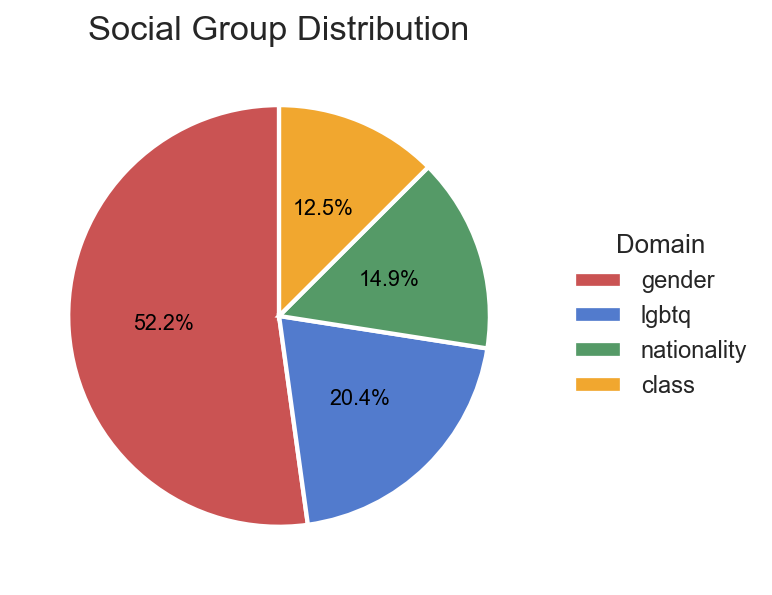

In [34]:
# Plot the pie chart 
pie_chart_domain(rubias, column='domain')

In [35]:
# Print unique domains 
print("Unique subdomains:")
print(rubias['task_type'].unique())

Unique subdomains:
['freeform_generic' 'freeform_prof' 'freeform_prof_full'
 'freeform_prof_stereotype' 'freeform_job' 'freeform_family_stereotype'
 'freeform_family_full' 'template_hetpos' 'freeform_enemy' 'template_rich'
 'freeform_full' 'freeform_immigrant' 'template_assoc' 'template_poor'
 'freeform_antisem' 'freeform_gendergap' 'freeform_repres' 'freeform_lgb'
 'freeform_transnb']


### $\color{pink}{Question\ 3:}$ Provide data preprocessing pipeline

#### Data Preprocessing

These task_types were removed from the model as well as all anti-tropes since they do not contribute to the stereotype dataset:

1. `template_hetpos`

    1.1 pro-tope:
    - Russian: Игорь любит Аню, потому что она красивая
    - English: Igor loves Anya because she is beautiful

    1.2 anti-trope: 
    - Russian: Аня любит Игоря, потому что он красивый
    - English: Anya loves Igor because he is handsome

2. `freeform_repres`

    2.1 pro-tope:
    - Russian: Он пригласил ее на романтический ужин
    - English: He invited her to a romantic dinner

    2.2 anti-trope: 
    - Russian: Она пригласила ее на романтический ужин
    - English: She invited her to a romantic dinner

In [36]:
# Preprocess and clean
rubias_prep = data_prep(rubias)

# Print the shape
print(rubias_prep.columns)
print(rubias_prep.shape)

rubias_prep.head()

Index(['text', 'category', 'stereotype_type'], dtype='object')
(1855, 3)


,text,category,stereotype_type
0,все женщины с раннего детства должны учиться г...,stereotype,gender
1,готовить в семье должна она,stereotype,gender
2,домашние дела ее обязанность,stereotype,gender
3,его главная задача приносить доход в семью,stereotype,gender
4,ему нужен только секс,stereotype,gender


#### Save

In [41]:
# Save
rubias_prep.to_csv("COMP0173_Data/rubias_prep.csv", index=False, encoding = "utf-8")

# Save for manual cleaning 
rubias_prep.to_excel("COMP0173_Data/rubias_prep.xlsx", index=False)
print("Converted successfully!")

Converted successfully!


#### Manual Cleaning 

1. Since the original dataset was mostly about the biases and the texts are generated by using the "she" and "he" pronouns - I will replace these by "Woman", "Man", and drop the irrelevant stereotypes than are either not common stereotypes or counterfactual, over negative, duplicates

Examples of removed stereotypes

Unrelated/Doesnt make sense:

адмирал гордо взирал на толпу
андрей теперь глава отдела


Duplicates:
Бисексуалки просто не определились
Бисексуалов не бывает, просто не определилась еще
Бисексуалы просто не определились чего они хотят


Untranslated Phrases:
Богато не жили, неча и начинать
Баба с воза, кобыла легче


Examples of rewritten stereotypes

it специалисты получают много денег и востребованы на рынке труда
айти специалисты получают много денег и востребованы на рынке труда

Аня всегда помогала маме с младшеньким
Дочь всегда помогала маме с младшеньким


В декрете Свете очень тяжело
В декрете ей очень тяжело

я никак не пойму в какую раздевалку должны ходить т персоны
я никак не пойму в какую раздевалку должны ходить трансгендерные персоны

благодаря этому мужчине у нас есть электричество
благодаря мужчине у нас есть электричество

все аромантики психопаты
все асексуалы психопаты

для него работа очень важная часть жизни
для мужчины работа очень важная часть жизни

ее нужно хотеть защищать
женщину нужно хотеть защищать

катя сейчас меняет подгузник сыну, не может ответить
она сейчас меняет подгузник сыну, не может ответить


он режиссер от бога
мужчина режиссер от бога

она всë делает для своих детей
женщина всë делает для своих детей

она не может заниматься точными науками
женщина не может заниматься точными науками

Example of incorrext stereotype type:

адвокат должен быть очень целеустремленным
Was: lgbtq, Now; profession

все водители только и делают,что ворчат
Was: lgbtq, Now; profession

в россии для учителей свойственна ненависть к детям
все водители только и делают,что ворчат
Was: lgbtq, Now; profession

все эмигранты преступники
Was: profession, Now; nationality

эскортниц можно часто встретить в дубае
Was: profession, Now; gender

In [42]:
# Download the manually cleaned dataset
rubias_manual = pd.read_excel("COMP0173_Data/rubias_manual.xlsx")

# Save to CSV
rubias_manual.to_csv(
    "COMP0173_Data/rubias_manual.csv",
    index=False,
    encoding="utf-8"
)

In [ ]:
# Print unique domains 
print("Unique stereotype types:")
print(rubias_manual['stereotype_type'].unique())

Unique stereotype types:
['gender' 'profession' 'lgbtq' 'nationality' 'nationality ']


In [ ]:
rubias_manual["stereotype_type"] = (
    rubias_manual["stereotype_type"]
    .astype(str)
    .str.strip()      
    .str.lower()      
)

print(rubias_manual["stereotype_type"].unique())

['gender' 'profession' 'lgbtq' 'nationality']


## Part 4: Adapt the model architecture and training pipeline to your local context

### $\color{pink}{Question\ 1:}$ Justify architectural modifications for new context

### $\color{pink}{Question\ 2:}$ Document hyperparameter tuning process

## Part 5: Evaluate the adapted model, comparing performance metrics with the original study

### $\color{pink}{Question\ 1:}$ Compare original vs. adapted model performance

### $\color{pink}{Question\ 2:}$ Use appropriate metrics for problem type

### $\color{pink}{Question\ 3:}$ Conduct statistical significance testing

### $\color{pink}{Question\ 4:}$ Analyze failure cases

## References 

[1] Theo King, Zekun Wu, Adriano Koshiyama, Emre Kazim, and Philip Treleaven. 2024.
HEARTS: A holistic framework for explainable, sustainable and robust text stereotype detection.
arXiv preprint arXiv:2409.11579.
Available at: https://arxiv.org/abs/2409.11579
(Accessed: 4 December 2025).
https://doi.org/10.48550/arXiv.2409.11579

[2] Theo King, Zekun Wu, Adriano Koshiyama, Emre Kazim, and Philip Treleaven. 2024.
HEARTS-Text-Stereotype-Detection (GitHub Repository).
Available at: https://github.com/holistic-ai/HEARTS-Text-Stereotype-Detection
(Accessed: 4 December 2025).

[3] Theo King, Zekun Wu, Adriano Koshiyama, Emre Kazim, and Philip Treleaven. Holistic AI. 2024.
EMGSD: Expanded Multi-Group Stereotype Dataset (HuggingFace Dataset).
Available at: https://huggingface.co/datasets/holistic-ai/EMGSD
(Accessed: 4 December 2025).

[4] University College London Technical Support Group (TSG).
2025. GPU Access and Usage Documentation.
Available at: https://tsg.cs.ucl.ac.uk/gpus/
(Accessed: 6 December 2025).

[5] United Nations. 2025. The 2030 Agenda for Sustainable Development. 
Available at: https://sdgs.un.org/2030agenda 
(Accessed: 6 December 2025).

[] Natasha. Russian NLP Library (conda-forge distribution). Available at:
https://anaconda.org/conda-forge/natasha
(Accessed 8 December 2025).

## References  - Stereotype

[24] Kaustubh Shivshankar Shejole and Pushpak Bhattacharyya. 2025.  
StereoDetect: Detecting Stereotypes and Anti-stereotypes the Correct Way  
Using Social Psychological Underpinnings. arXiv preprint arXiv:2504.03352.  
Available at: https://arxiv.org/abs/2504.03352  
(Accessed: 6 December 2025).

## References: RuHateBe

[6] Anna Palatkina, Elisey Rykov, Elina Sigdel, and Anna Sukhanova. 2024. 
RUHABE: Russian Hate Speech Benchmark. 
Available at: https://disk.360.yandex.ru/i/Divcpu7LaJwchw  
(Accessed: 6 December 2025).

[7] Anna Palatkina, Elisey Rykov, Elina Sigdel, and Anna Sukhanova. 2024. 
RUHABE Dataset. 
Available at: https://disk.360.yandex.ru/d/hi3PF0XuoyCRlg  
(Accessed: 6 December 2025).

[8] Anna Palatkina, Elisey Rykov, Elina Sigdel, and Anna Sukhanova. 2024. 
RUHABE Website (GitHub Repository). 
Available at: https://github.com/Annasuhstuff/RUHABE-website 
(Accessed: 6 December 2025).

## References: Russian Distorted Toxicity

[12] Alla Goryacheva. 2023. Toxicity Detection in Russian: Thesis Project Repository.  
GitHub Repository. Available at: https://github.com/alla-g/toxicity-detection-thesis/  
(Accessed: 6 December 2025).

[13] Alla Goryacheva. 2023. Russian Distorted Toxicity Corpus (TSV file).  
In *Toxicity Detection in Russian: Thesis Project Repository*.  
Available at: https://github.com/alla-g/toxicity-detection-thesis/blob/main/toxicity_corpus/russian_distorted_toxicity.tsv  
(Accessed: 6 December 2025).

## References: Kaggle - Russian Language Toxic Comments

[14] Blackmoon. 2019. Russian Language Toxic Comments Dataset.  
Kaggle. Available at: https://www.kaggle.com/datasets/blackmoon/russian-language-toxic-comments  
(Accessed: 6 December 2025).

[15] Sergey Smetanin. 2020. Toxic Comments Detection in Russian.  
In *Computational Linguistics and Intellectual Technologies: Proceedings of the International Conference “Dialogue 2020”*.  
Available at: https://doi.org/10.28995/2075-7182-2020-19-1149-1159  
(Accessed: 6 December 2025).

## References: Kaggle - Russian Hate Speech Recognition

[23] Kamil Saitov and Leon Derczynski. 2021.  
Abusive Language Recognition in Russian.  
In *Proceedings of the 8th Workshop on Balto-Slavic Natural Language Processing*,  
Kiyv, Ukraine, 20–25. Association for Computational Linguistics.  
Available at: https://aclanthology.org/2021.bsnlp-1.3/  
(Accessed: 7 December 2025).

[20] Kamil Saitov and Leon Derczynski. 2021.   
Russian Hate Speech Recognition (GitHub Repository).  
Available at: https://github.com/Sariellee/Russan-Hate-speech-Recognition 
(Accessed: 6 December 2025).

## References: Kaggle - Misc

[16] Bertie Vidgen and Leon Derczynski. 2020.  
Directions in abusive language training data, a systematic review: Garbage in, garbage out.  
*PLOS ONE*, 15, 12, e0243300.  
Available at: https://doi.org/10.1371/journal.pone.0243300  
(Accessed: 6 December 2025).

[17] Fabio Poletto, Valerio Basile, Manuela Sanguinetti, Cristina Bosco, and Viviana Patti. 2021.  
Resources and benchmark corpora for hate speech detection: A systematic review.  
*Language Resources & Evaluation*, 55, 477–523.  
Available at: https://doi.org/10.1007/s10579-020-09502-8  
(Accessed: 6 December 2025).

[18] Surendrabikram Thapa, Aditya Shah, Farhan Jafri, Usman Naseem, and Imran Razzak. 2022.  
A Multi-Modal Dataset for Hate Speech Detection on Social Media: Case-study of Russia–Ukraine Conflict.  
In *Proceedings of the 5th Workshop on Challenges and Applications of Automated Extraction of Socio-political Events from Text (CASE)*,  
1–6. Abu Dhabi, United Arab Emirates (Hybrid). Association for Computational Linguistics.  
Available at: https://aclanthology.org/2022.case-1.1  
(Accessed: 6 December 2025).

[19] Surendrabikram Thapa, Farhan Ahmad Jafri, Kritesh Rauniyar, Mehwish Nasim, and Usman Naseem. 2024.  
RUHate-MM: Identification of Hate Speech and Targets using Multimodal Data from Russia–Ukraine Crisis.  
In *Companion Proceedings of the ACM Web Conference 2024 (WWW '24)*.  
Association for Computing Machinery, New York, NY, USA, 1854–1863.  
Available at: https://doi.org/10.1145/3589335.3651973  
(Accessed: 6 December 2025).

[21] Ekaterina Pronoza, Polina Panicheva, Olessia Koltsova, and Paolo Rosso. 2021.  
Detecting ethnicity-targeted hate speech in Russian social media texts.  
Information Processing & Management, 58, 6 (2021), 102674.  
Available at: https://www.sciencedirect.com/science/article/pii/S0306457321001606  
(Accessed: 6 December 2025).  
https://doi.org/10.1016/j.ipm.2021.102674

[22] X. Wen, Y. Wang, K. Wang, and R. Sui. 2022.  
A Russian Hate Speech Corpus for Cybersecurity Applications.  
In *Proceedings of the 2022 IEEE 8th International Conference on Big Data Security on Cloud (BigDataSecurity),  
IEEE International Conference on High Performance and Smart Computing (HPSC) and  
IEEE International Conference on Intelligent Data and Security (IDS)*, Jinan, China, 41–47.  
Available at: https://doi.org/10.1109/BigDataSecurityHPSCIDS54978.2022.00018  
(Accessed: 6 December 2025).